# Chirp Processing steps for A11

The setup of this notebook is to define a simple function to call on the RAW A11 data that returns a profile variable that we can use in our further analysis. The notebook will first build out the workflow before defining the function at the end

# Setup

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    22:30:18 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    22:30:18 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    22:30:18 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
ds_101 = reload("A101")
ds_101 = ds_101.isel(time=range(20,len(ds_101.time))) # trim first few bursts, which were tests

ds_101_w = reload_winter("A101")

ds_101_s = reload_summer("A101")


In [3]:
# open client
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38703")
client

<Client: 'tcp://127.0.0.1:38703' processes=4 threads=16, memory=125.81 GiB>

# Identifying summer thresholds

In [4]:
# trim to test
#ds_101 = ds_101.isel(time=range(4000,6000))

The following plot is a histogram for A11 summer.

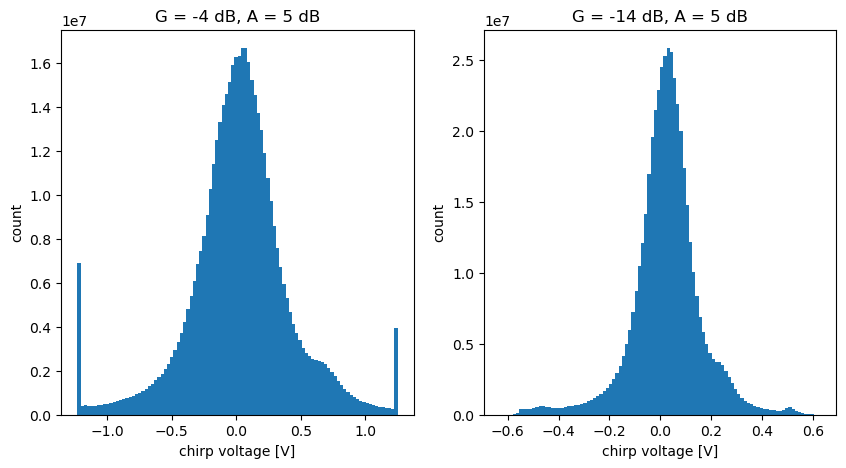

In [5]:
# take summer and plot histogram to identify attenuator settings and thresholds
plot_hist(ds_101)

Next, we plot the maximum and mean chirp magnitudes. The first row is taking these values across each chirp number and burst, the second row is taken across each chirp and burst, and the third is taken across each chirp and chirp number.

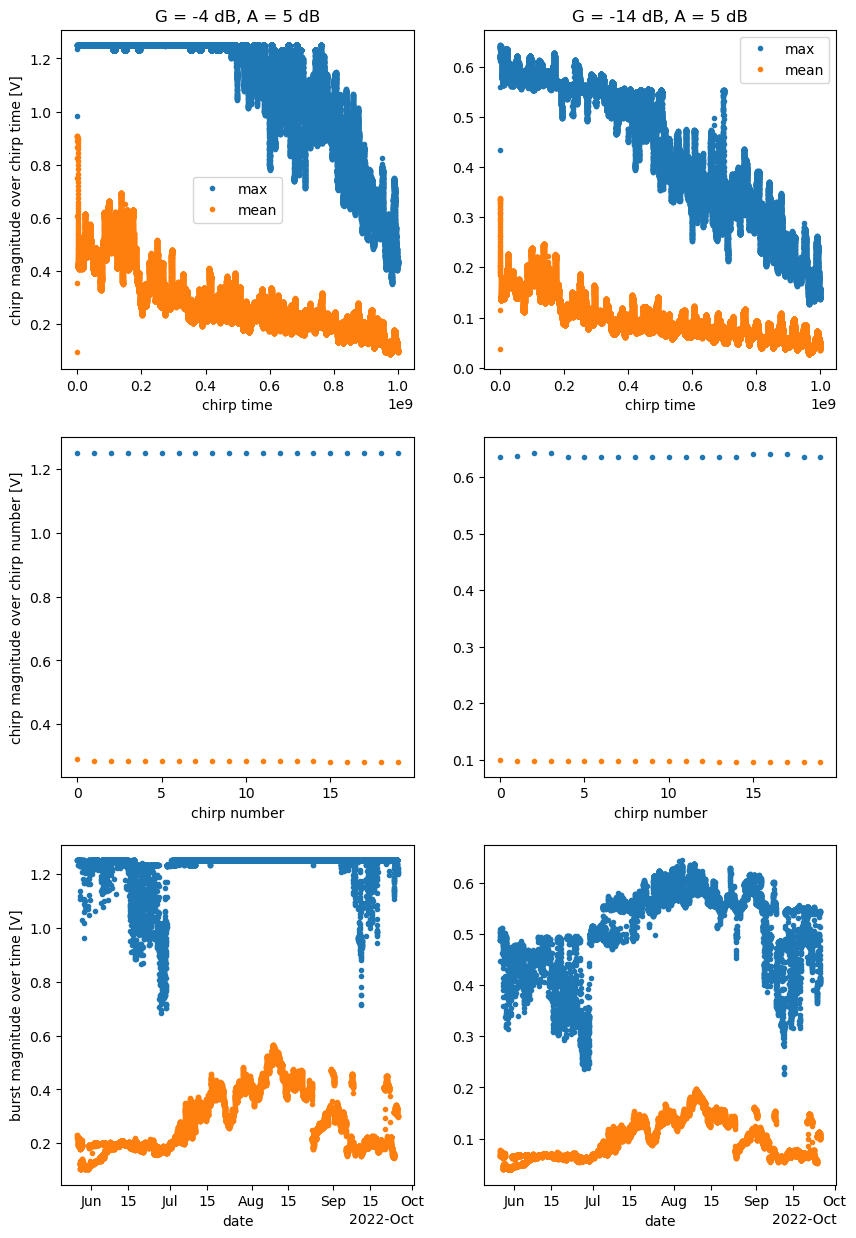

In [6]:
plot_amplitude_trends(ds_101)

Given the above plots, we pick the first set of attenuation settings and a threshold for clipping of 1.2 V. 

Next, we plot the total number of instances of clipping for each sampling point in every single chirp, the fraction of total clipped chirps as a distribution over chirp number, and the total number of clipped chirps in each burst. We do this to identify areas where we can filter out clipping.

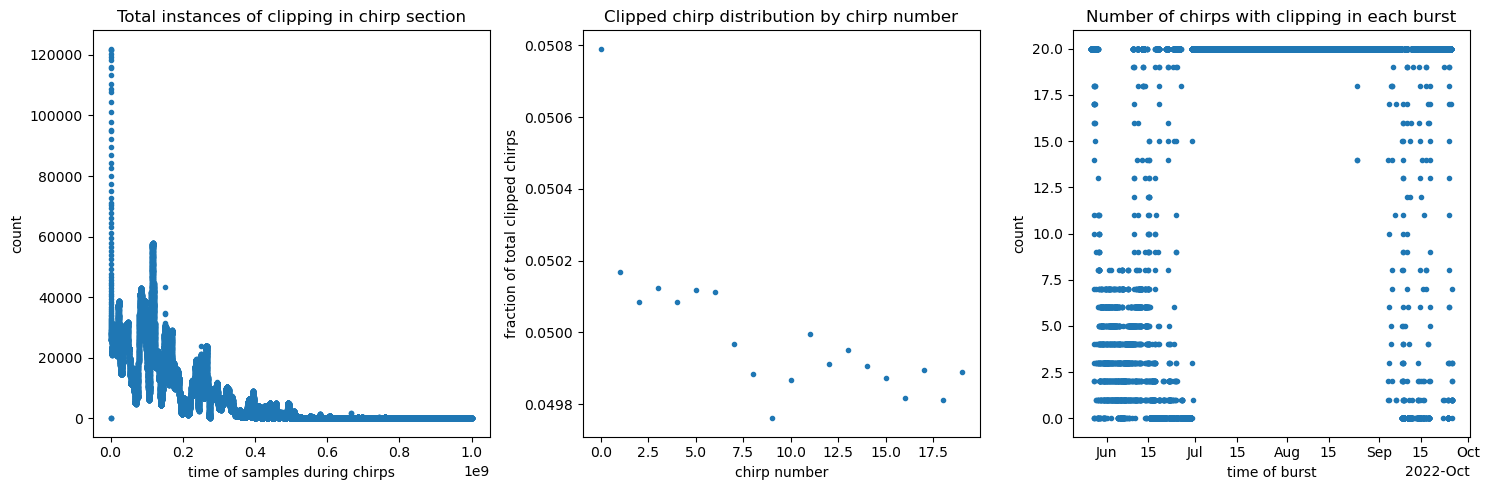

In [4]:
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

From this, we choose to apply a half chirp. Repeating the plots, we see that while instances of clipping are greatly reduced, they're not enitrely eliminated.

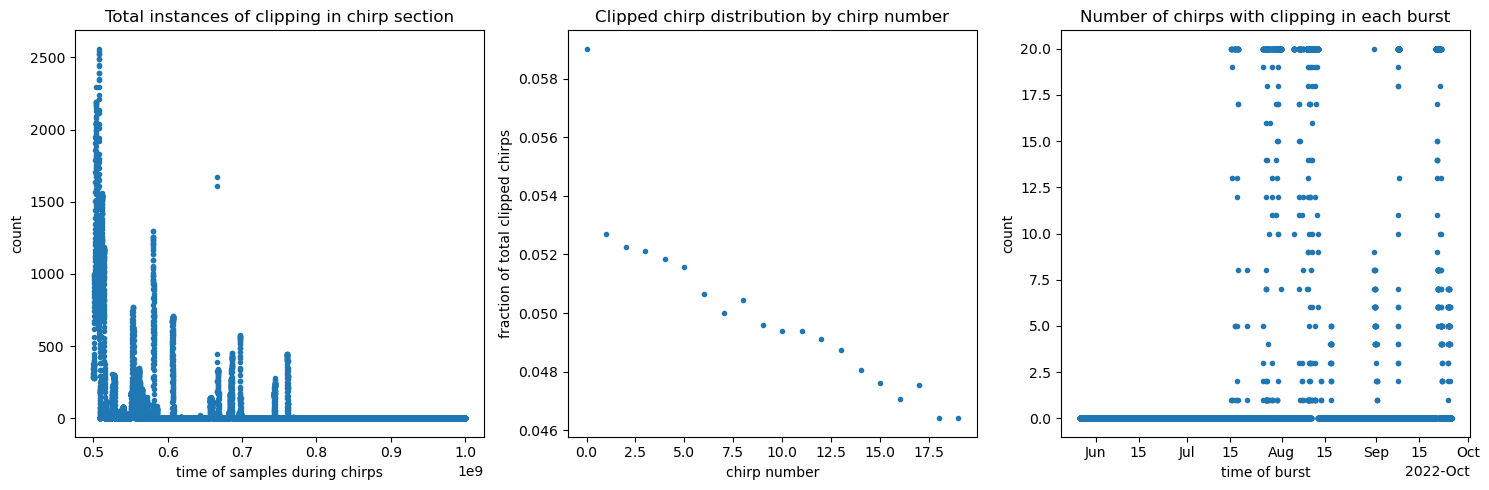

In [8]:
# half waveform
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Still seems like many instances of clipping. We now choose to drop up to 15 chirps that have clipping each burst. A seperate investigation shows that using fewer chirps in a stack results in a higher noise floor, but the upper englacial reflectors are preserved. We choose to retain at least 5 chirps as a default. Consequently if 15 chirps or more in a burst are labelled as clipped, we drop that entire burst from the timeseries. 

We now calculate profiles. We have picked our attenuator setting (0), our clipping threshold (1.2 V) and our min number of unclipped chirps in a burst (5). We make a new function that generates profiles given those choices. 

In [5]:
test = custom_profile(ds_101.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=20000)

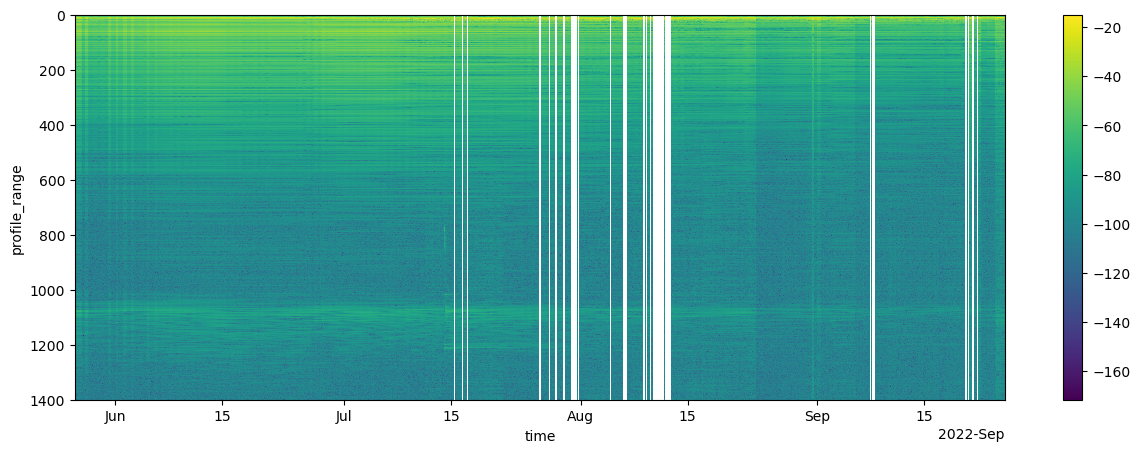

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()


Now try with slightly stricter bounds

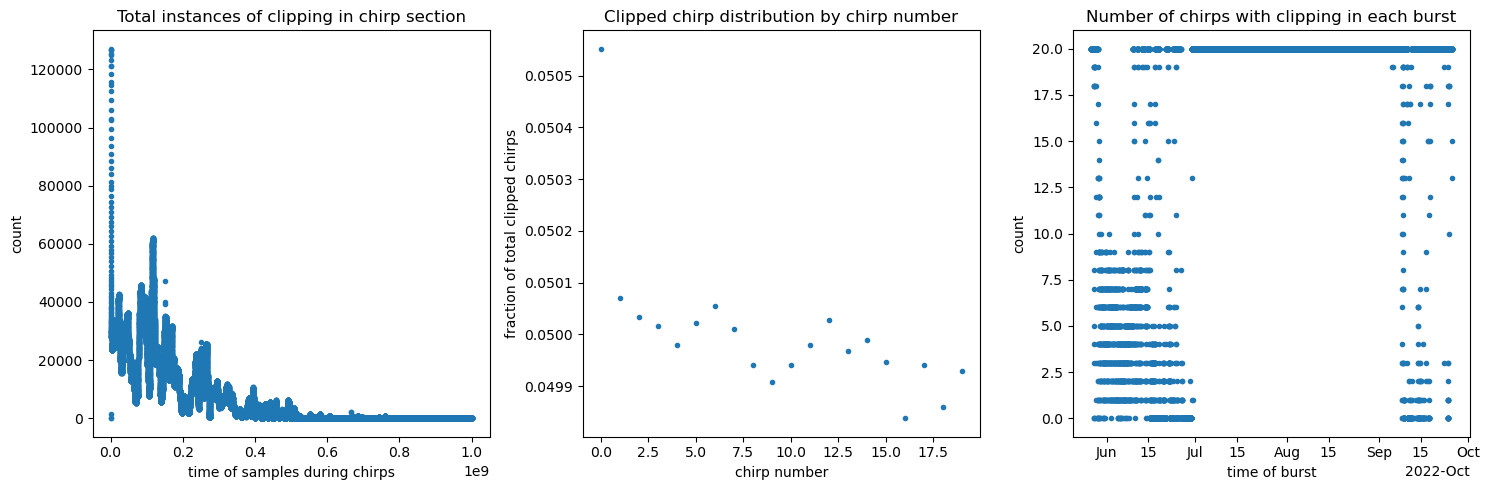

In [7]:
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.15

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

In [8]:
test = custom_profile(ds_101.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.15,min_chirps = 5,start=20000)

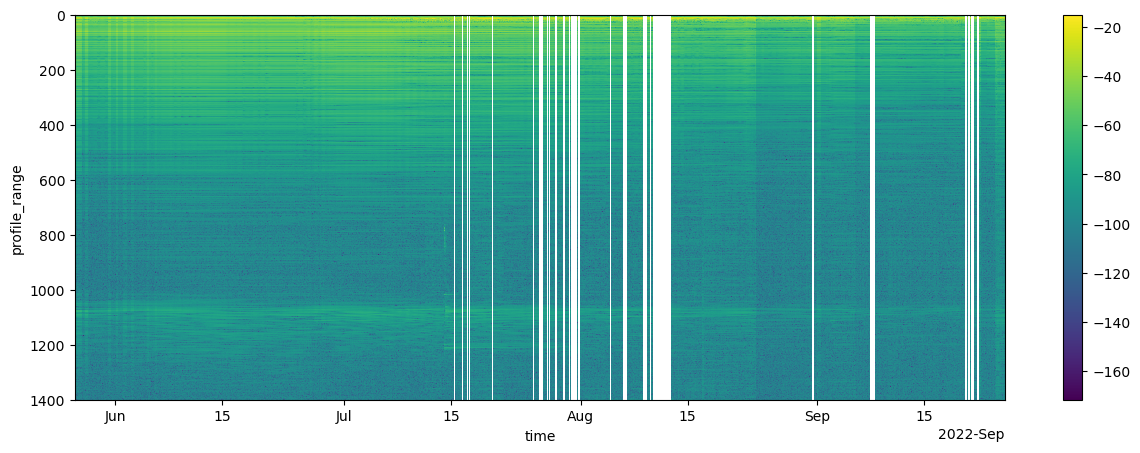

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()


In [10]:
test = custom_profile(ds_101.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.15,min_chirps = 5,start=30000)

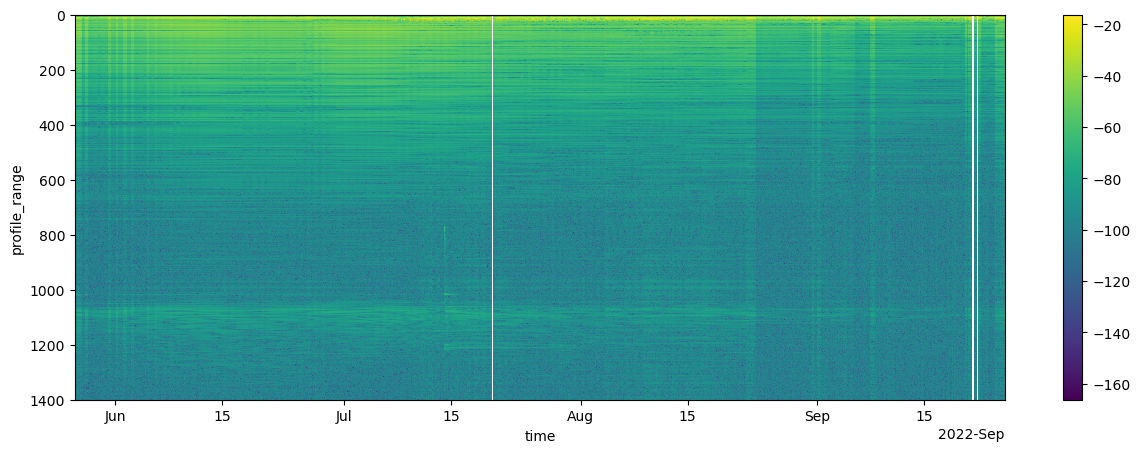

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()


Compare to without processing for clipping

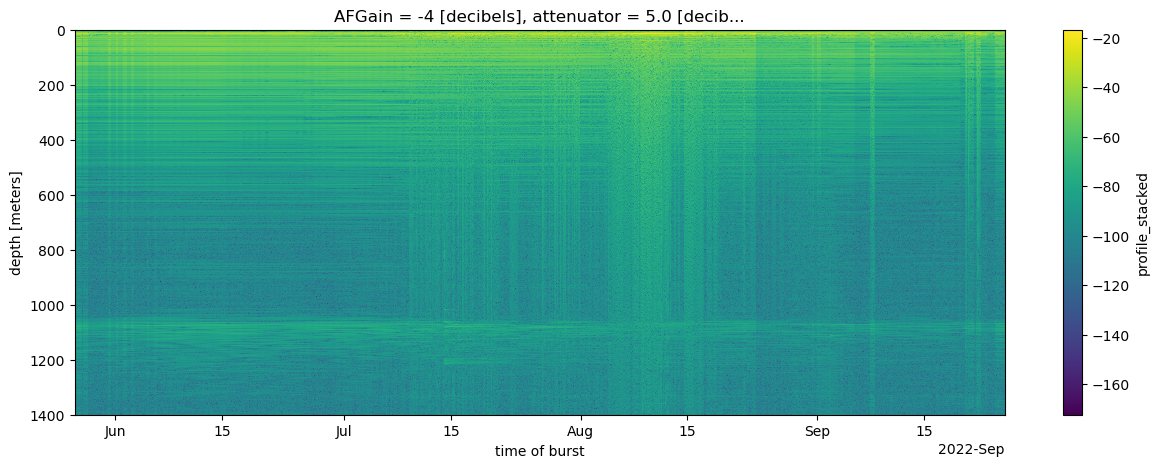

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

xa.dB(ds_101.isel(attenuator_setting_pair=0).profile_stacked).plot(x='time')
ax.invert_yaxis()

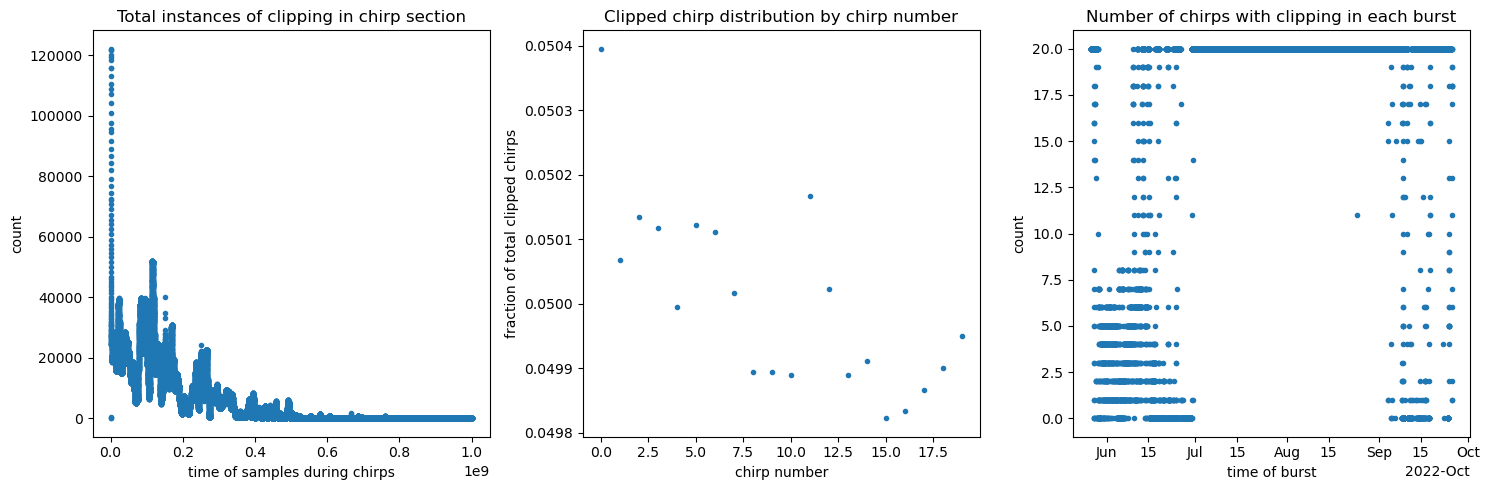

In [19]:
# Test with other settings
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=1).chirp) > 0.4

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=1).chirp.where(bad_chirp_condition))

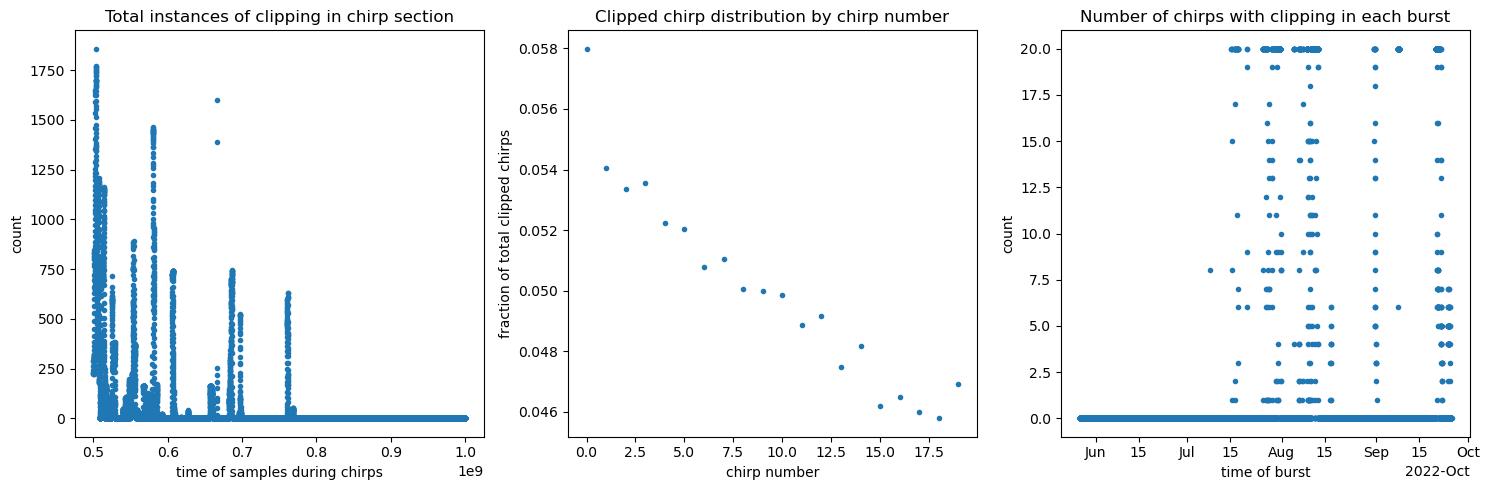

In [20]:
# half waveform
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=1).chirp) > 0.4

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=1,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

In [6]:
test1 = custom_profile(ds_101.isel(attenuator_setting_pair=1).chirp,clip_threshold=0.4,min_chirps = 5,start=20000)

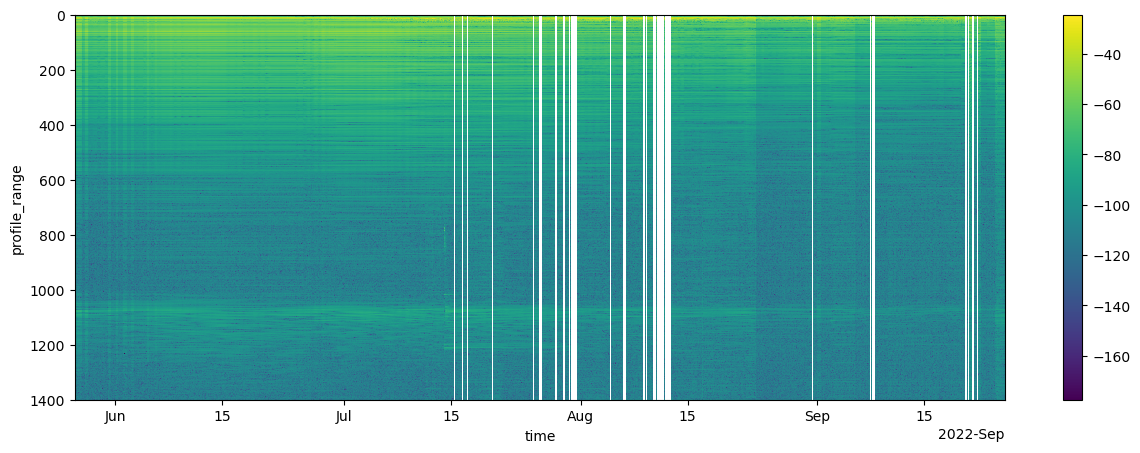

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test1).plot(x='time')
ax.invert_yaxis()

Similar, though we were stricter

# Winter

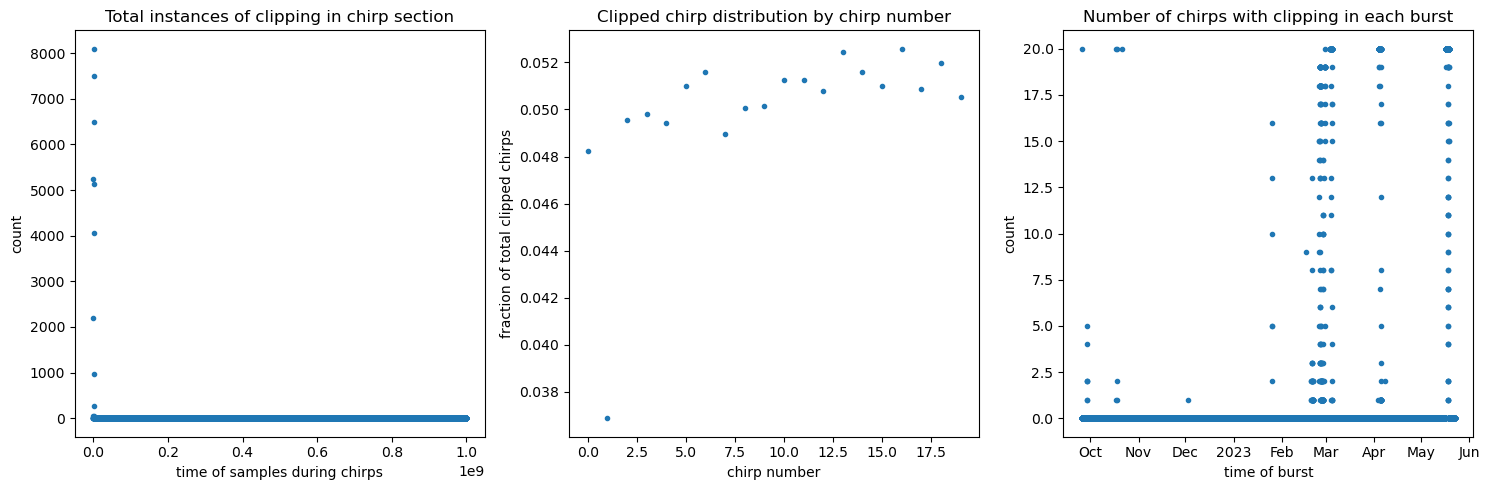

In [14]:
bad_chirp_condition = abs(ds_101_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101_w.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

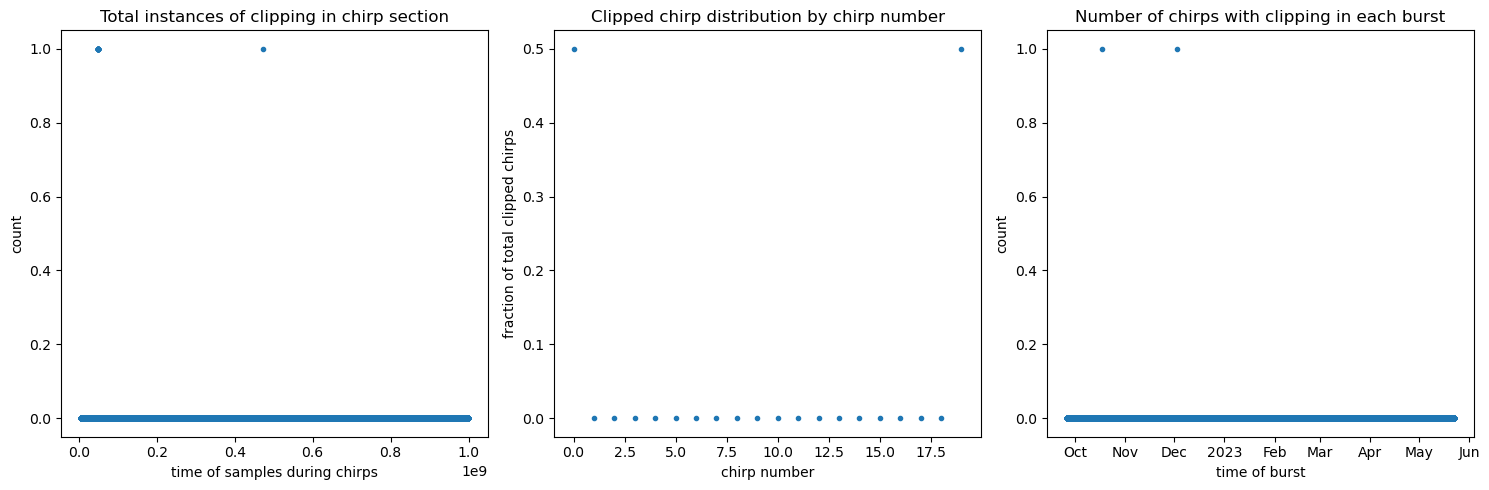

In [15]:
plot_bad_chirp_count(ds_101_w.isel(attenuator_setting_pair=0,chirp_time=range(200,39999)).chirp.where(bad_chirp_condition))

In [12]:
test = custom_profile(ds_101_w.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=200)

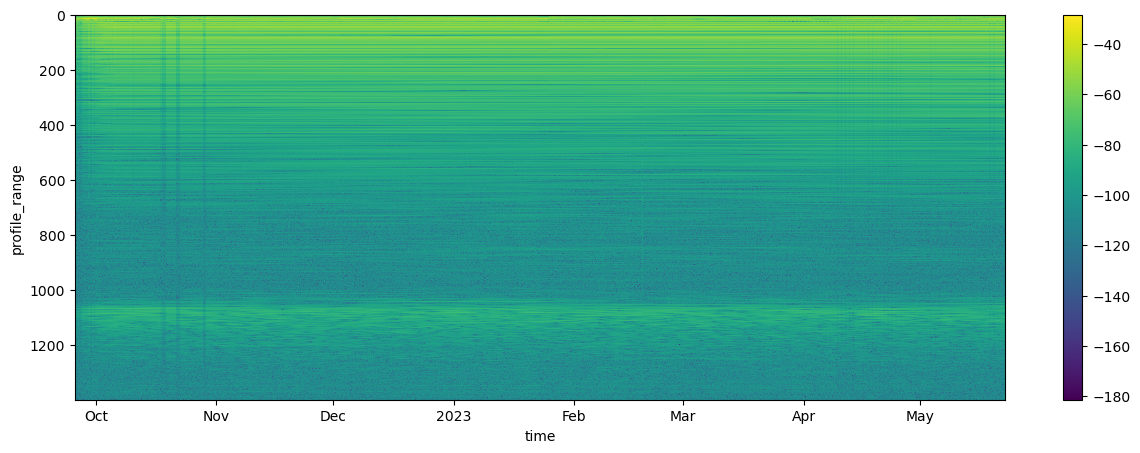

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()


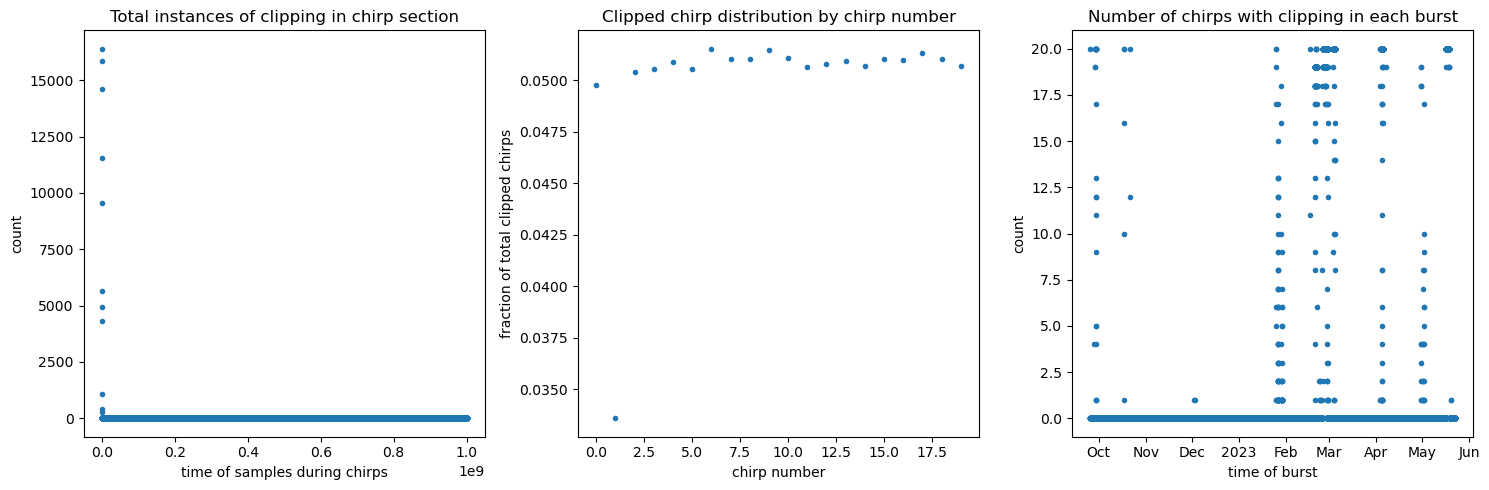

In [14]:
bad_chirp_condition = abs(ds_101_w.isel(attenuator_setting_pair=0).chirp) > 1.15

plot_bad_chirp_count(ds_101_w.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

In [67]:
test = custom_profile(ds_101_w.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.15,min_chirps = 5,start=200)

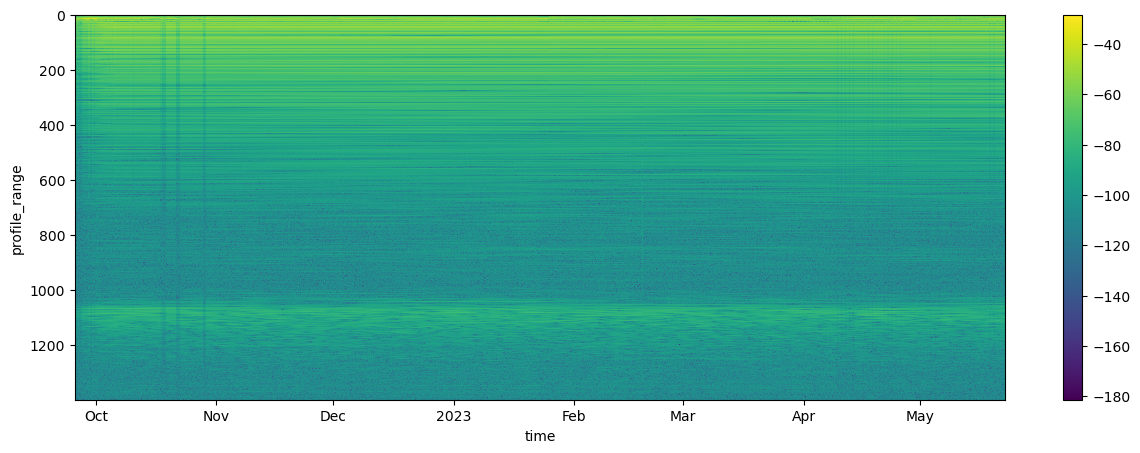

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()


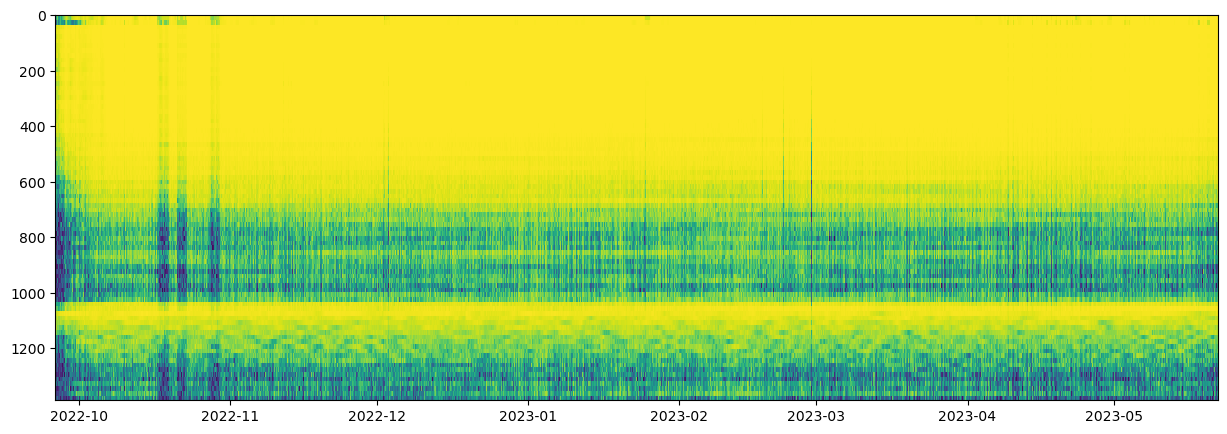

In [69]:
lag = 96
window = 80
b1= test.isel(time=range(0,len(test)-lag))
b2 = test.isel(time=range(lag,len(test)))
ds_20, co_20, phi_20 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_20=ds_20.assign(coherence=(['time','profile_range'],co_20))
ds_20['doy_decimal'] = ds_20.time.dt.dayofyear + (ds_20.time.dt.hour / 24) + (ds_20.time.dt.minute / 1440) + (ds_20.time.dt.second / 86400)
fig, ax = plt.subplots(figsize=(15,5))

plt.pcolormesh(ds_20.time,ds_20.profile_range,np.abs(co_20).T,vmin=0,vmax=1)
ax.invert_yaxis()

In [70]:
ds_20 = ds_20.where(abs(ds_20.coherence) > 0.95).drop_duplicates('time')
vv_20 = ds_20.range_diff / ds_20.time_diff * 31536000
vv_20_err = ds_20.err / ds_20.time_diff * 31536000
fit_20=vv_20.where(vv_20.profile_range <=600).polyfit('profile_range',1,full=True)
r2_20 = 1-fit_20.polyfit_residuals/((vv_20.where(vv_20.profile_range <=600)-vv_20.where(vv_20.profile_range <=600).mean())**2).sum(dim='profile_range')
fit_20['doy_decimal'] = fit_20.time.dt.dayofyear + (fit_20.time.dt.hour / 24) + (fit_20.time.dt.minute / 1440) + (fit_20.time.dt.second / 86400)


Text(0, 0.5, 'r$^2$')

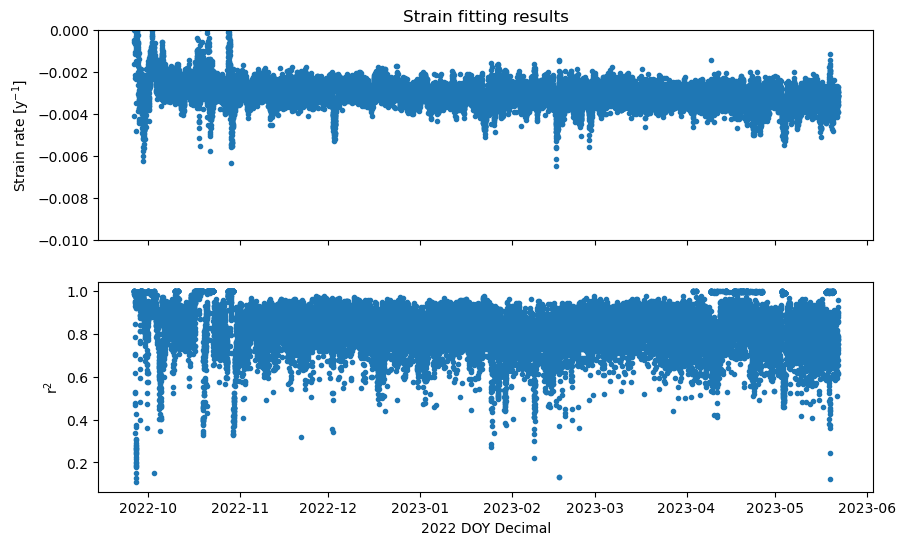

In [71]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
axs[0].plot(fit_20.time.values,fit_20.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='Chirps 1-20')
#axs[0].set_ylim([-1e-2,1e-2])
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
axs[0].set_ylim([-0.01, 0])

axs[1].plot(fit_20.time.values,r2_20.values,linestyle='None',marker='.')

axs[1].set_xlabel('2022 DOY Decimal')
axs[1].set_ylabel('r$^2$')

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

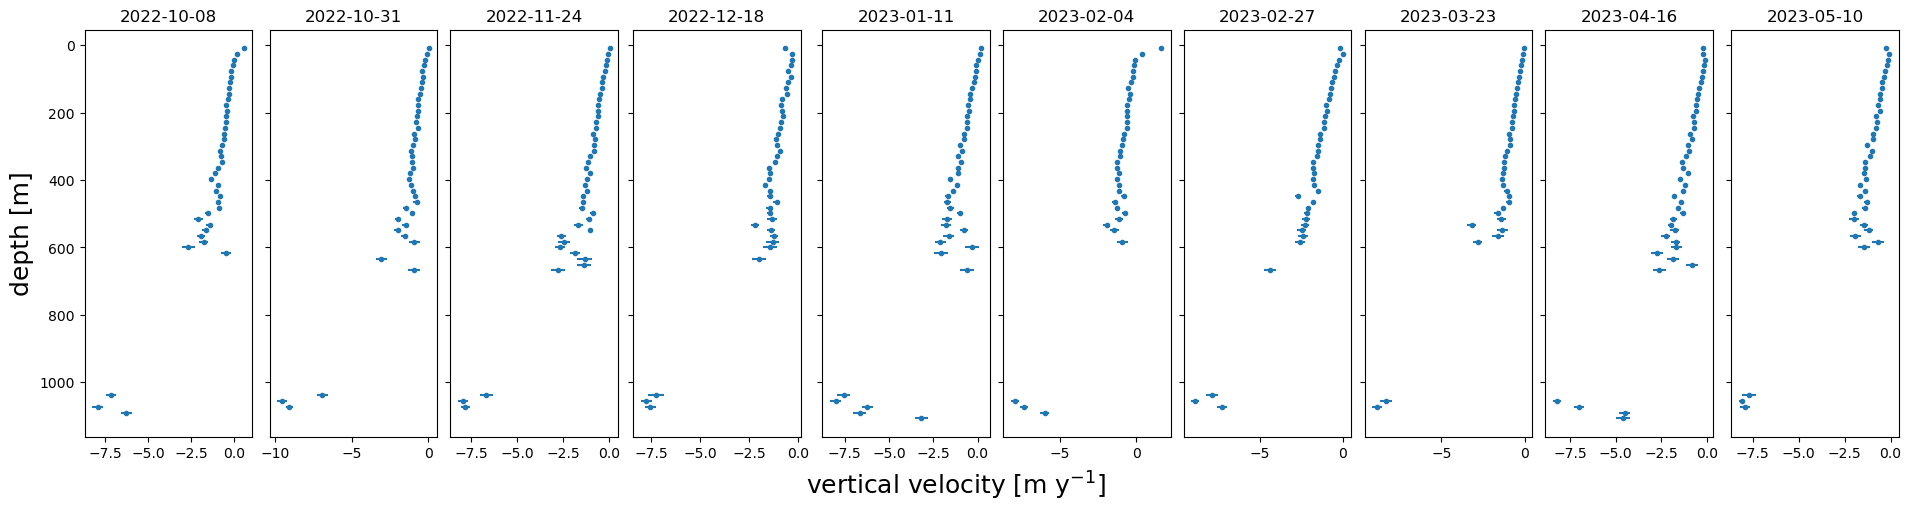

In [72]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv_times = np.arange(math.ceil(0.05*len(vv_20.time)),len(vv_20.time),len(vv_20.time)//10)
for i in range(10):
    time = vv_20.time.isel(time = vv_times[i]).values
    axs_1[i].errorbar(vv_20.sel(time = time,method="nearest") ,vv_20.profile_range,yerr=None,xerr=vv_20_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=1)
    #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

    #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[i].set_title(f'{time.astype(str)[:10]}')
    


axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

Text(0.5, 0, 'vertical velocity [m y$^{-1}$]')

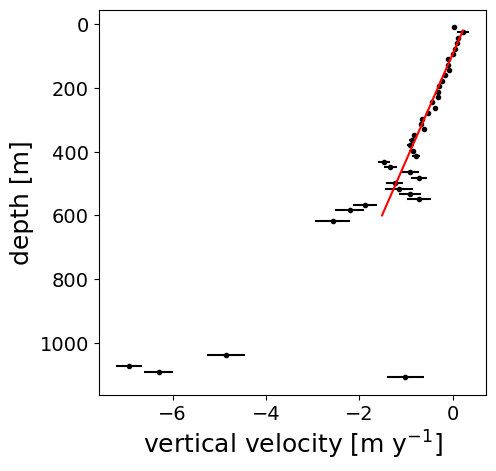

In [78]:
fig,ax = plt.subplots(figsize=(5,5))
t=1400
ax.errorbar(vv_20.isel(time = t) ,vv_20.profile_range,yerr=None,xerr=vv_20_err.isel(time = t),linestyle='',marker='.',color='k',zorder=1)
slope = fit_20.polyfit_coefficients.sel(degree=1).isel(time=t).values*np.linspace(20,600)+fit_20.polyfit_coefficients.sel(degree=0).isel(time=t).values
ax.plot(slope,np.linspace(20,600),color='r',zorder=2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.invert_yaxis()
ax.set_ylabel('depth [m]',fontsize=18)
ax.set_xlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
#ax.set_xlim([-75,5])

In [ ]:
# profiles with other settings


In [8]:
test = custom_profile(ds_101_w.isel(attenuator_setting_pair=1).chirp,clip_threshold=0.4,min_chirps = 5,start=200)

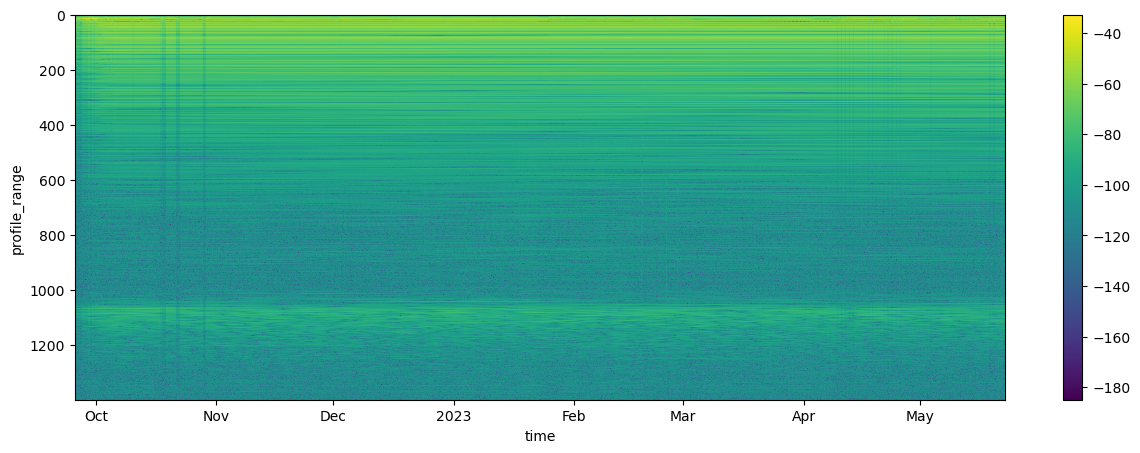

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()

In [4]:
# test looking at lake drainage
ds_101 = ds_101.isel(time=range(4600,4700))

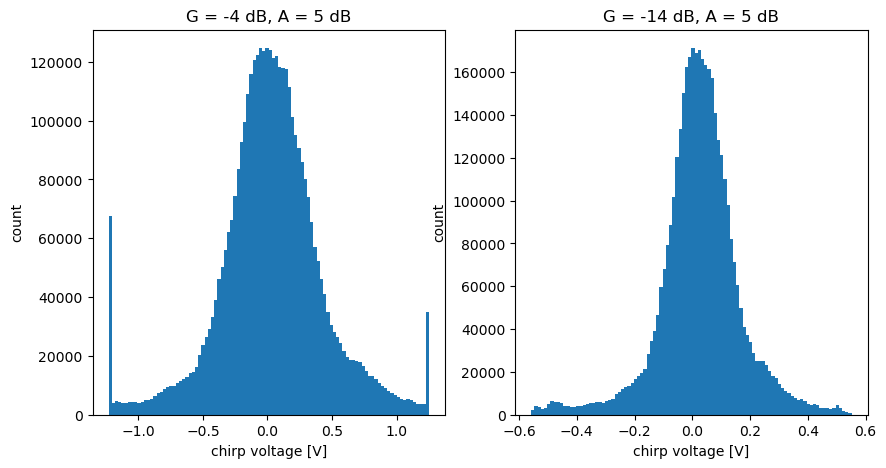

In [6]:
plot_hist(ds_101)

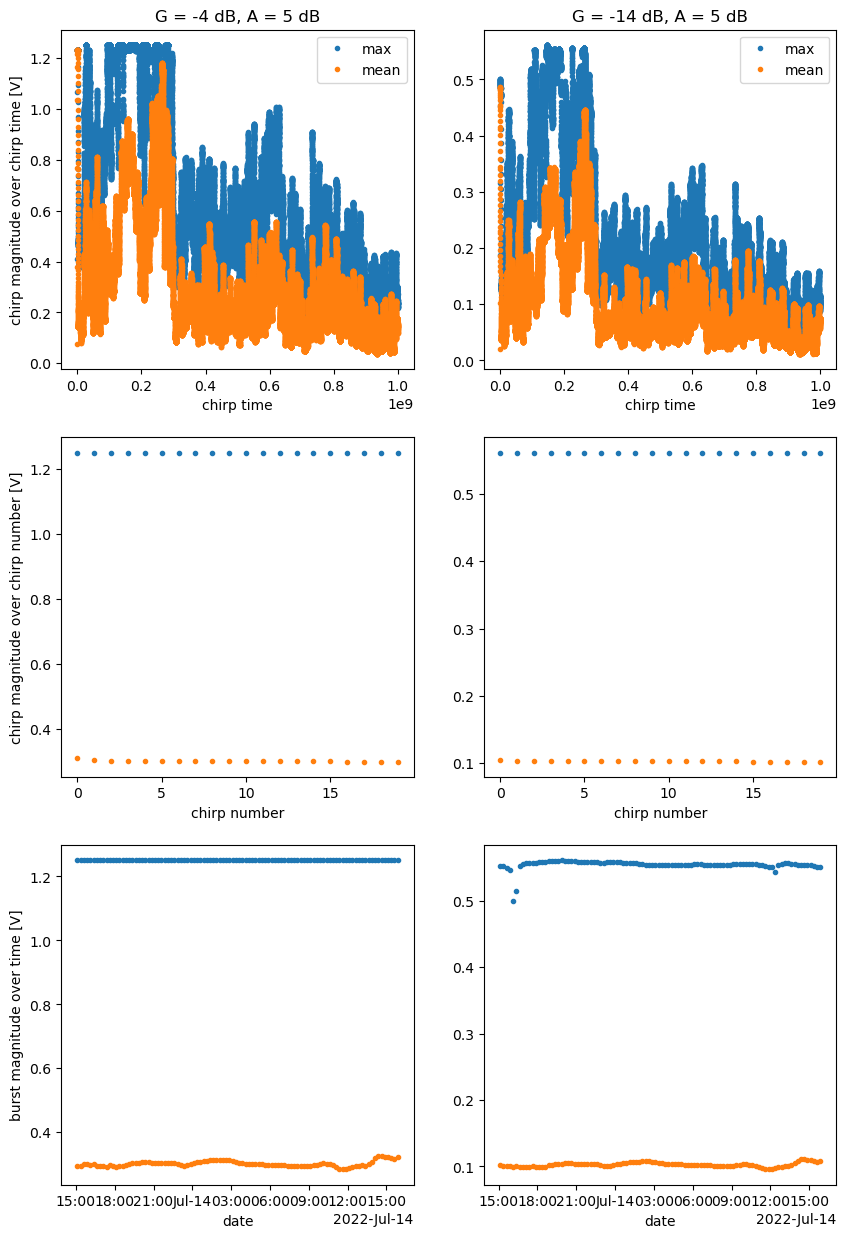

In [7]:
plot_amplitude_trends(ds_101)

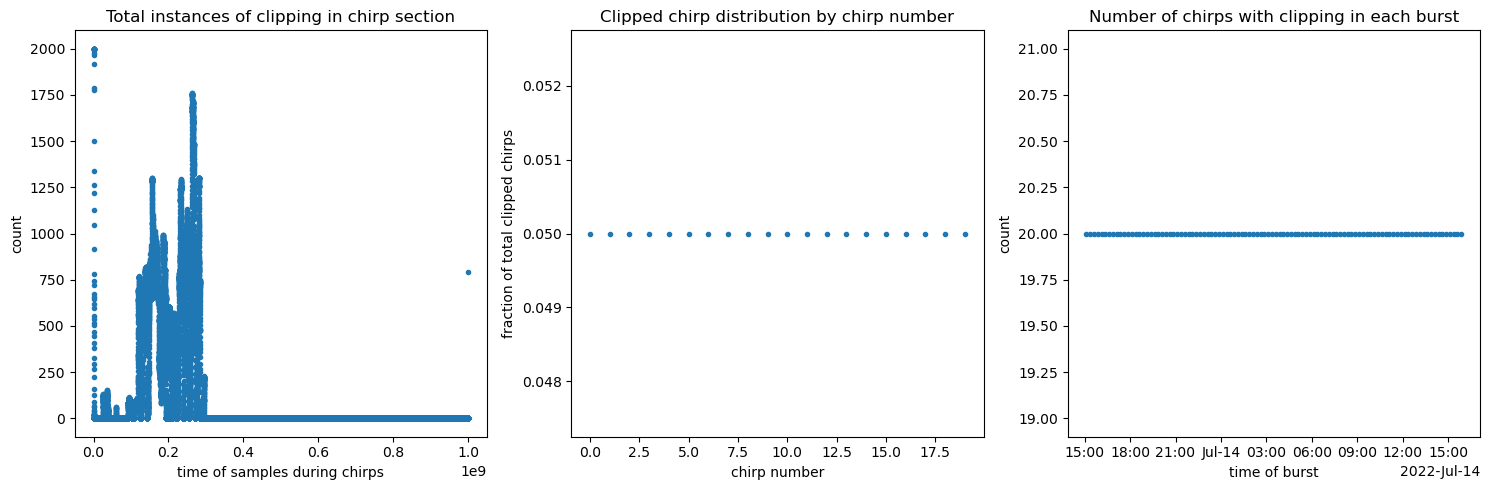

In [10]:
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

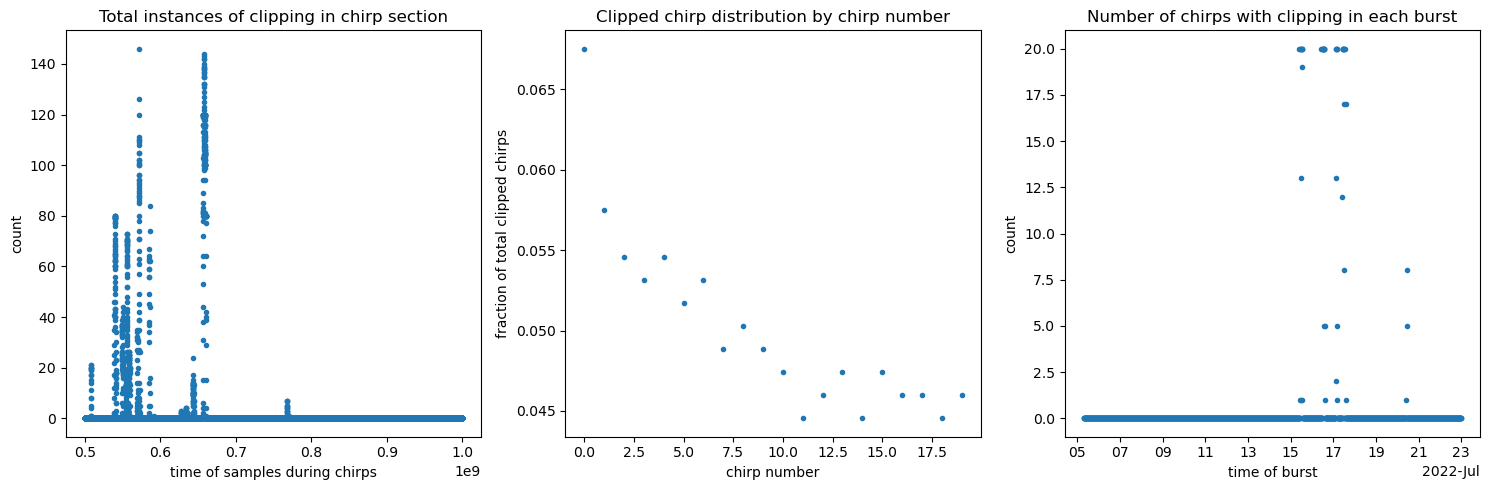

In [9]:
# half waveform
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

In [5]:
test = custom_profile(ds_101.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=20000)

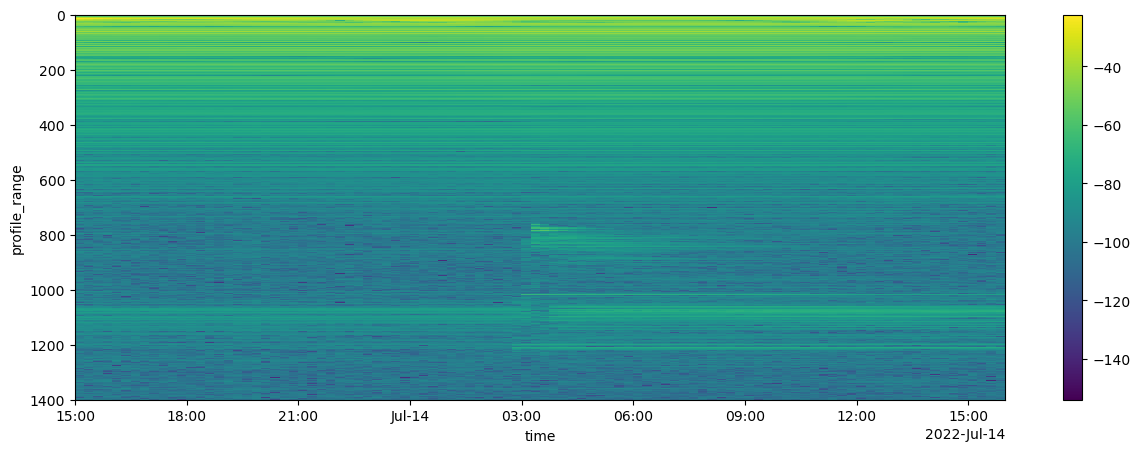

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()

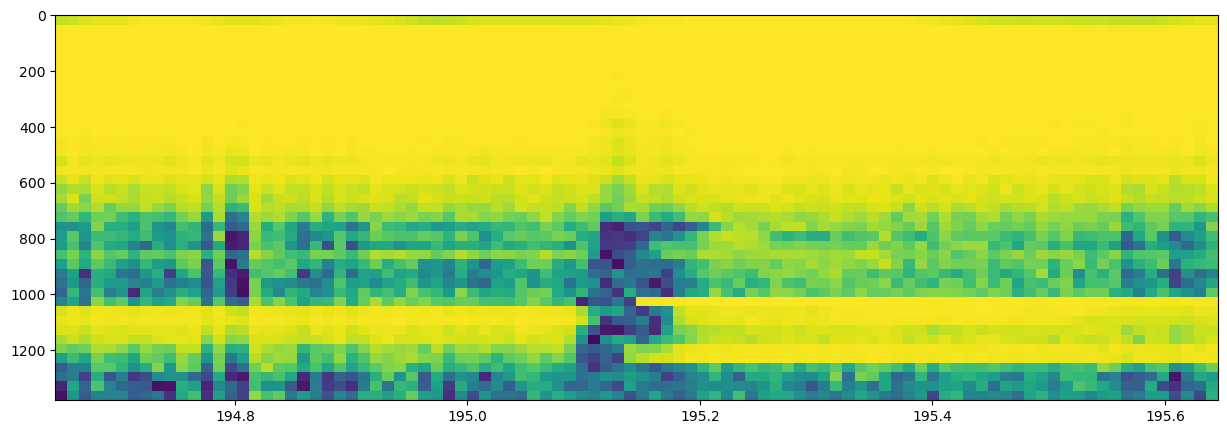

In [7]:
lag = 4
window = 80
b1= test.isel(time=range(0,len(test)-lag))
b2 = test.isel(time=range(lag,len(test)))
ds_20, co_20, phi_20 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_20=ds_20.assign(coherence=(['time','profile_range'],co_20))
ds_20['doy_decimal'] = ds_20.time.dt.dayofyear + (ds_20.time.dt.hour / 24) + (ds_20.time.dt.minute / 1440) + (ds_20.time.dt.second / 86400)
fig, ax = plt.subplots(figsize=(15,5))

plt.pcolormesh(ds_20.doy_decimal,ds_20.profile_range,np.abs(co_20).T,vmin=0,vmax=1)
ax.invert_yaxis()

In [8]:
ds_20 = ds_20.where(abs(ds_20.coherence) > 0.95).drop_duplicates('time')
vv_20 = ds_20.range_diff / ds_20.time_diff * 31536000
vv_20_err = ds_20.err / ds_20.time_diff * 31536000
fit_20=vv_20.where(vv_20.profile_range <=600).polyfit('profile_range',1,full=True)
r2_20 = 1-fit_20.polyfit_residuals/((vv_20.where(vv_20.profile_range <=600)-vv_20.where(vv_20.profile_range <=600).mean())**2).sum(dim='profile_range')
fit_20['doy_decimal'] = fit_20.time.dt.dayofyear + (fit_20.time.dt.hour / 24) + (fit_20.time.dt.minute / 1440) + (fit_20.time.dt.second / 86400)


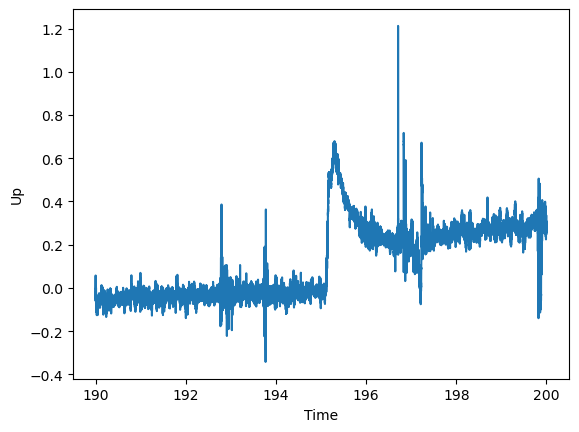

In [9]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq11_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.Up.plot(x='Time')

(194.65, 195.65)

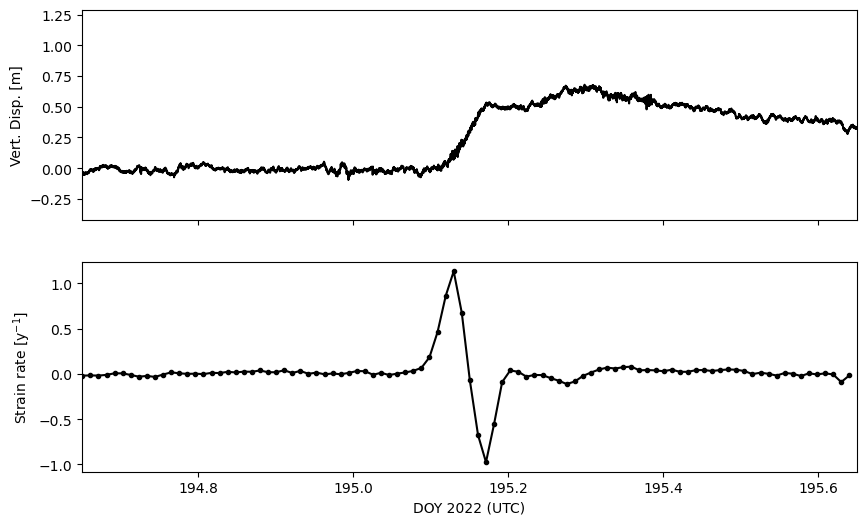

In [14]:
fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
axs[1].plot(fit_20.doy_decimal.values,fit_20.polyfit_coefficients.sel(degree=1).values,marker='.',color = 'k',label='Chirps 1-20')
#axs[0].set_ylim([-1e-2,1e-2])
axs[1].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Hourly strain fitting results')
#axs[0].set_ylim([-0.01, 0])

#axs[1].plot(fit_20.doy_decimal.values,r2_20.values,linestyle='None',marker='.')

#axs[1].set_ylabel('r$^2$')

data.Up.plot(ax=axs[0],x='Time',color='k')
axs[0].set_xlabel('')
axs[1].set_xlabel('DOY 2022 (UTC)')
axs[0].set_ylabel('Vert. Disp. [m]')
axs[0].set_xlim([194.65,195.65])

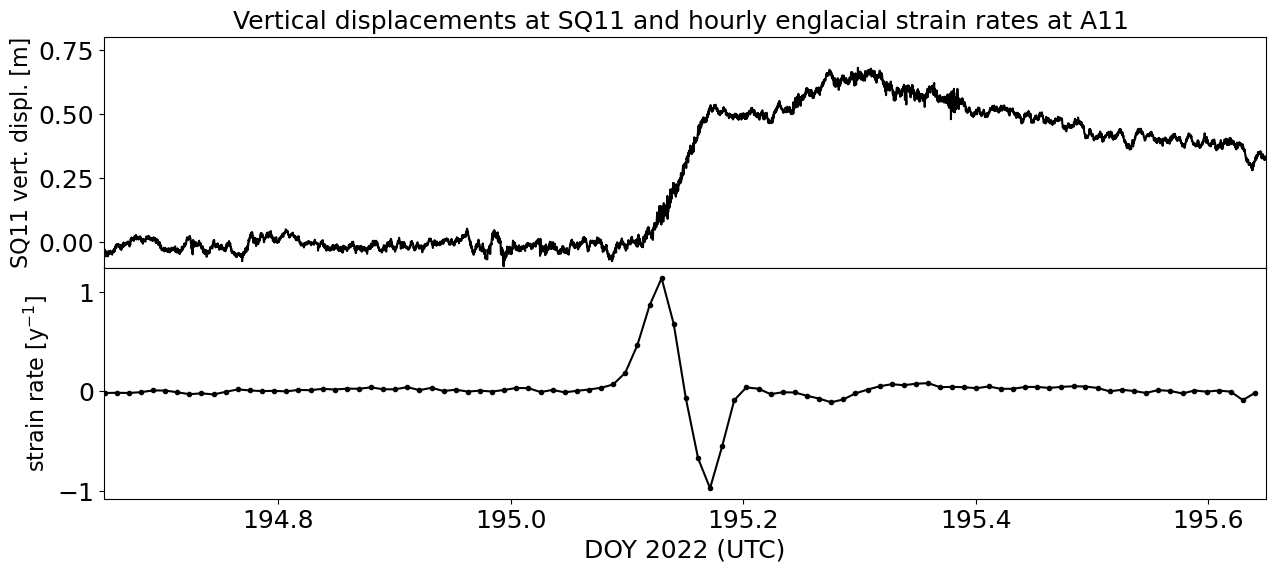

In [20]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True,gridspec_kw=dict(height_ratios=[1,1]),figsize=(15,6))

data.Up.plot(ax=ax1,x='Time',color='k',label='SQ11 vertical displacement')
ax1.set_ylabel('SQ11 vert. displ. [m]',fontsize=16)
ax1.set_xlabel('')
ax1.set_ylim([-0.1,0.8])
#ax1.yaxis.set_label_position("right")

ax1.set_title("Vertical displacements at SQ11 and hourly englacial strain rates at A11 ",fontsize=18)
ax1.set_xlim([194.65,195.65])
#ax1.yaxis.tick_right()
ax2.plot(fit_20.doy_decimal.values,fit_20.polyfit_coefficients.sel(degree=1).values,marker='.',color = 'k')

ax2.set_xlabel('DOY 2022 (UTC)',fontsize=18)
ax2.set_ylabel('strain rate [y$^{-1}$]',fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
plt.subplots_adjust(wspace=0, hspace=0)

pos = ax2.get_position()
pos2 = ax1.get_position()
ax1.set_position([pos.x0,pos2.y0,pos.width,pos2.height])
#ax2.legend(fontsize=18)
#plt.savefig('output_plot.png', transparent=True)


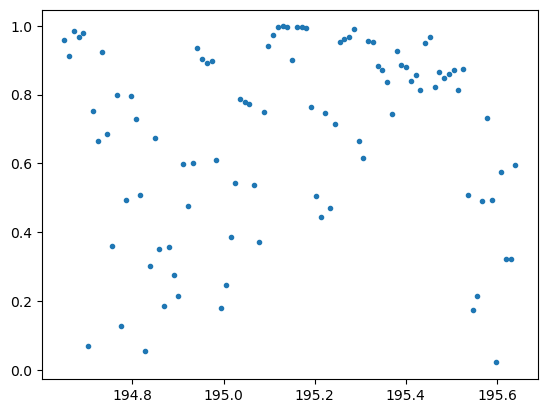

In [62]:
plt.plot(fit_20.doy_decimal.values,r2_20.values,linestyle='None',marker='.')

Text(0.5, 0, 'vertical velocity [m y$^{-1}$]')

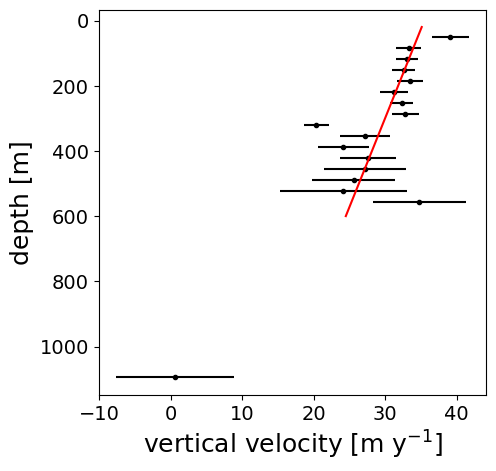

In [66]:
fig,ax = plt.subplots(figsize=(5,5))
t=2
ax.errorbar(vv_20.isel(time = t) ,vv_20.profile_range,yerr=None,xerr=vv_20_err.isel(time = t),linestyle='',marker='.',color='k',zorder=1)
slope = fit_20.polyfit_coefficients.sel(degree=1).isel(time=t).values*np.linspace(20,600)+fit_20.polyfit_coefficients.sel(degree=0).isel(time=t).values
ax.plot(slope,np.linspace(20,600),color='r',zorder=2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.invert_yaxis()
ax.set_ylabel('depth [m]',fontsize=18)
ax.set_xlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
#ax.set_xlim([-75,5])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

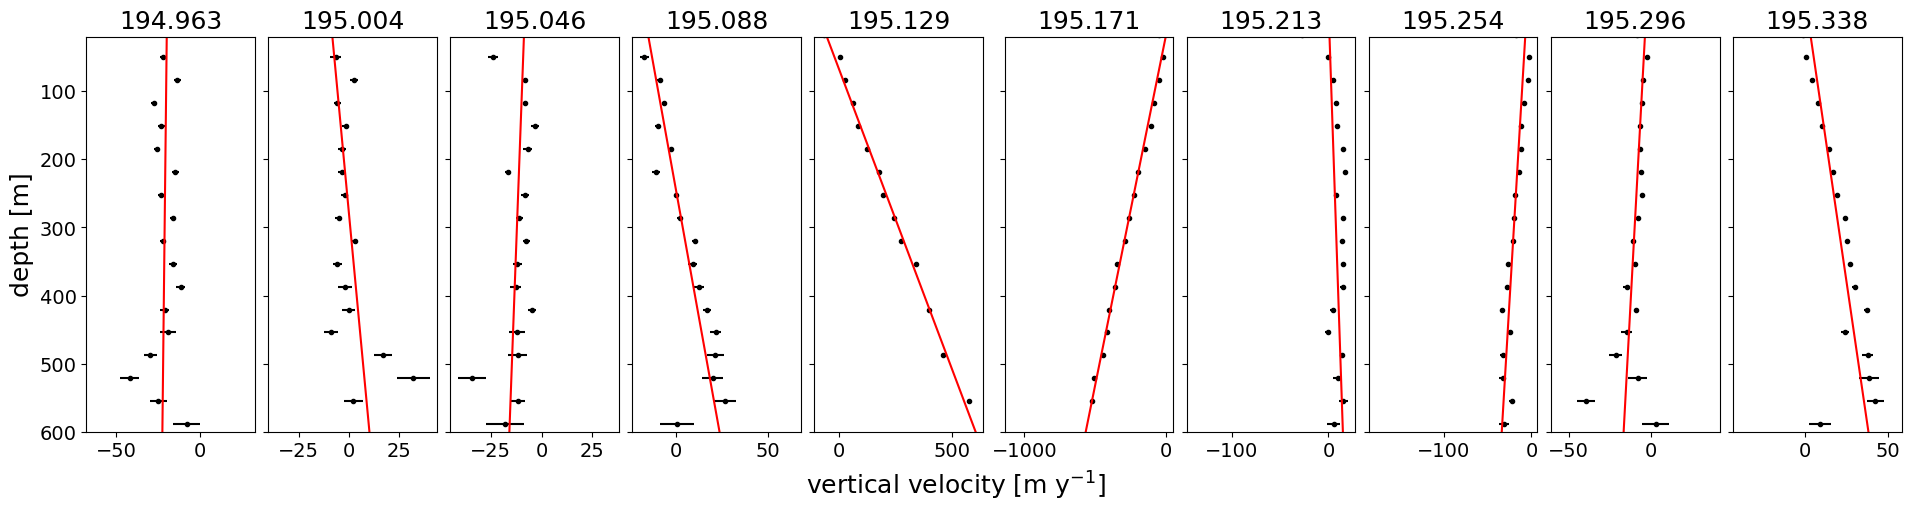

In [46]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv_20['doy_decimal'] = vv_20.time.dt.dayofyear + ((vv_20.time.dt.hour) / 24) + (vv_20.time.dt.minute / 1440) + (vv_20.time.dt.second / 86400)

plt_count = 0
for i in np.arange(30,70,4):
    axs_1[plt_count].errorbar(vv_20.isel(time = i) ,vv_20.profile_range,yerr=None,xerr=vv_20_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit_20.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit_20.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv_20.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-1000,250])
    axs_1[plt_count].set_ylim([20,600])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

 Test with visualizing nearly clipped data - use summer

In [55]:
snippet = ds_101.isel(attenuator_setting_pair = 0,time=range(4778,4788),chirp_time=range(20000,39999)).compute()

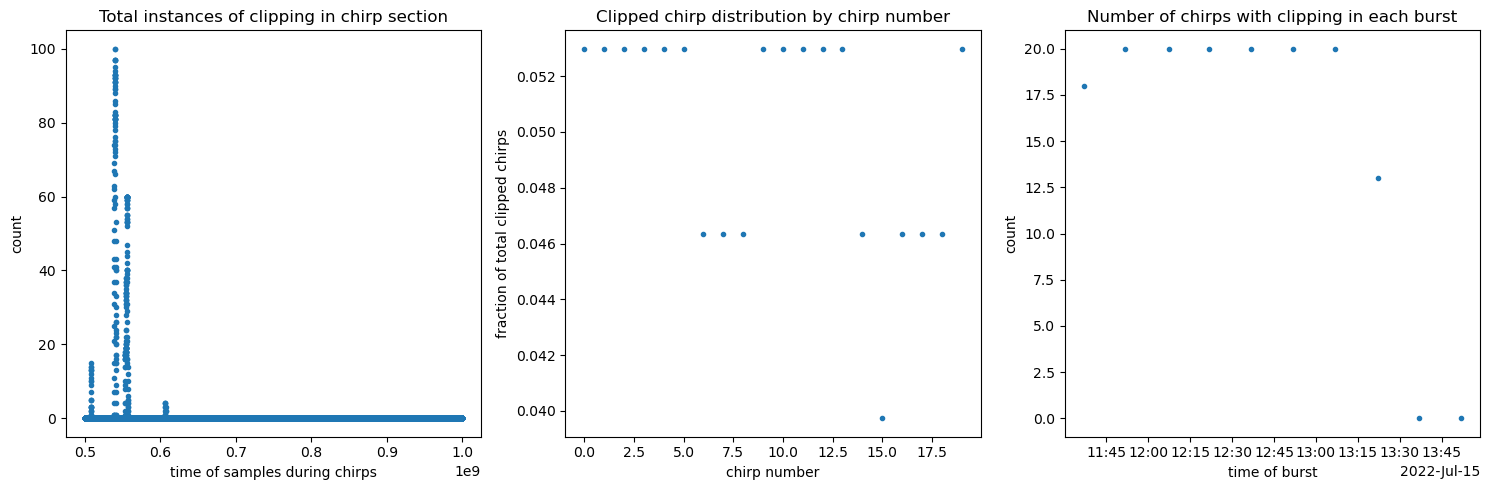

In [56]:
bad_chirp_condition = abs(snippet.chirp) > 1.15
plot_bad_chirp_count(snippet.chirp.where(bad_chirp_condition))

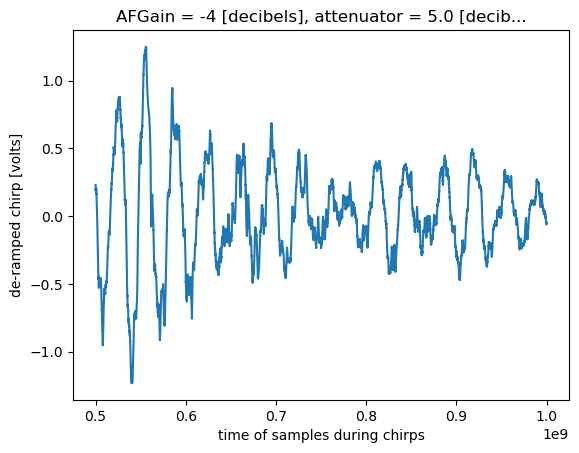

In [57]:
snippet.isel(time=3,chirp_num=0).chirp.plot()

(500000000.0, 700000000.0)

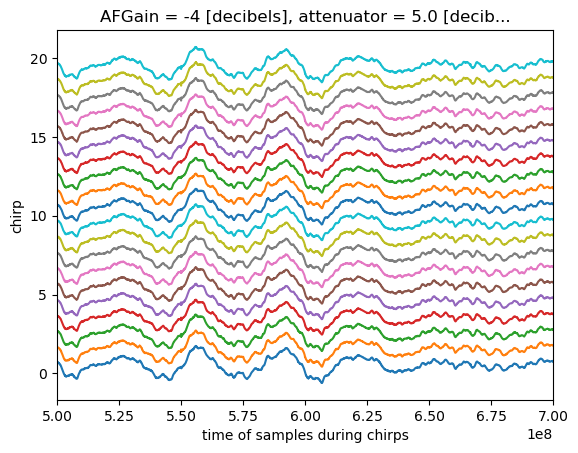

In [60]:
for i in range(20):
    (snippet.isel(time=1,chirp_num=i).chirp +i+0.5).plot()
plt.xlim([0.5e9,0.7e9])

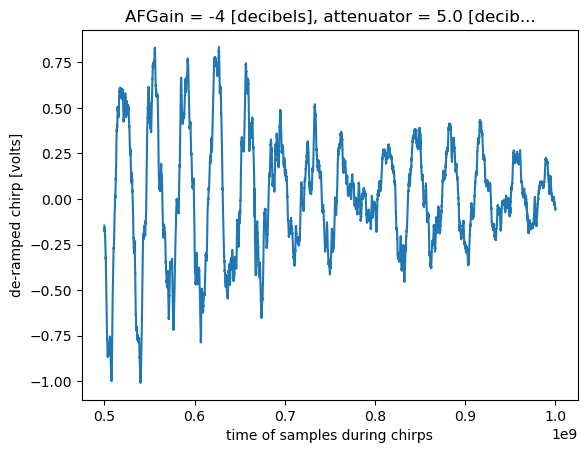

In [41]:
snippet.isel(time=9,chirp_num=5).chirp.plot()

Test with comparing profiles across different chirp counts 

In [30]:
snippet = ds_101.isel(attenuator_setting_pair = 0,time=range(4770,4800),chirp_time=range(20000,39999)).compute()

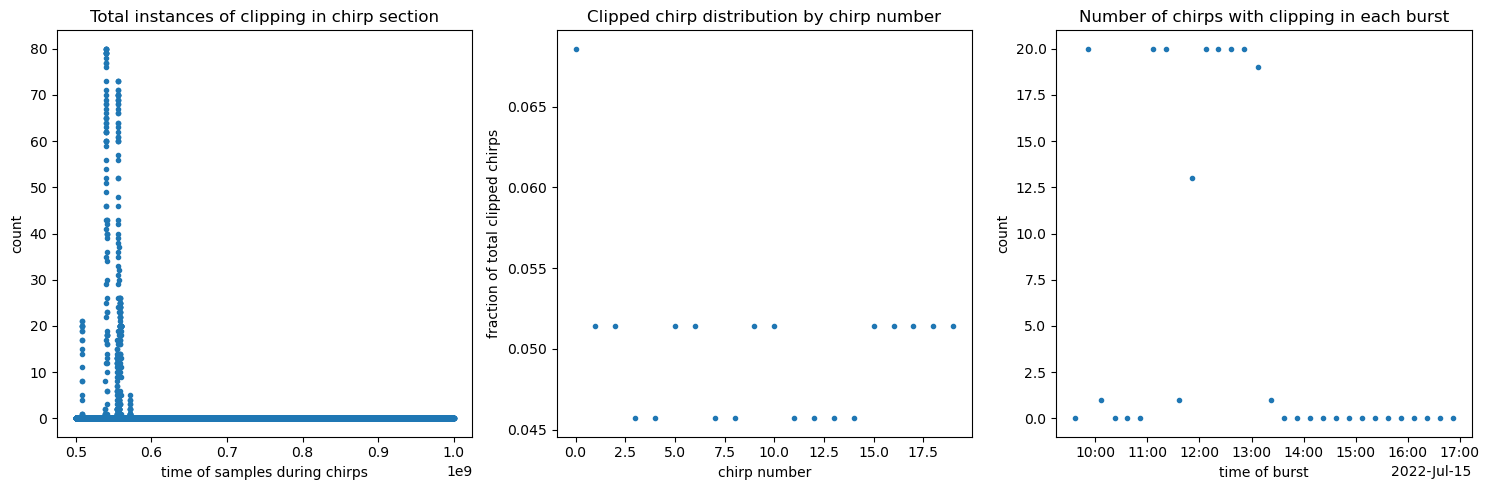

In [31]:
bad_chirp_condition = abs(snippet.chirp) > 1.2
plot_bad_chirp_count(snippet.chirp.where(bad_chirp_condition))

In [32]:
test = custom_profile(ds_101.isel(attenuator_setting_pair=0,time=range(4770,4800)).chirp,clip_threshold=1.2,min_chirps = 5,start=20000)

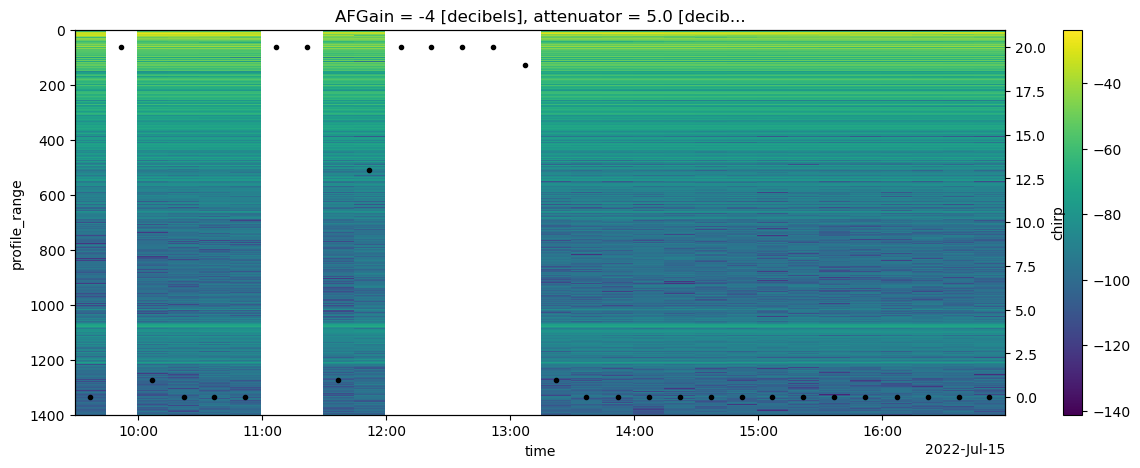

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()
ax1=ax.twinx()
snippet.chirp.where(bad_chirp_condition).max(dim='chirp_time').count(dim='chirp_num').plot(ax=ax1,linestyle='None',marker='.',color='k')

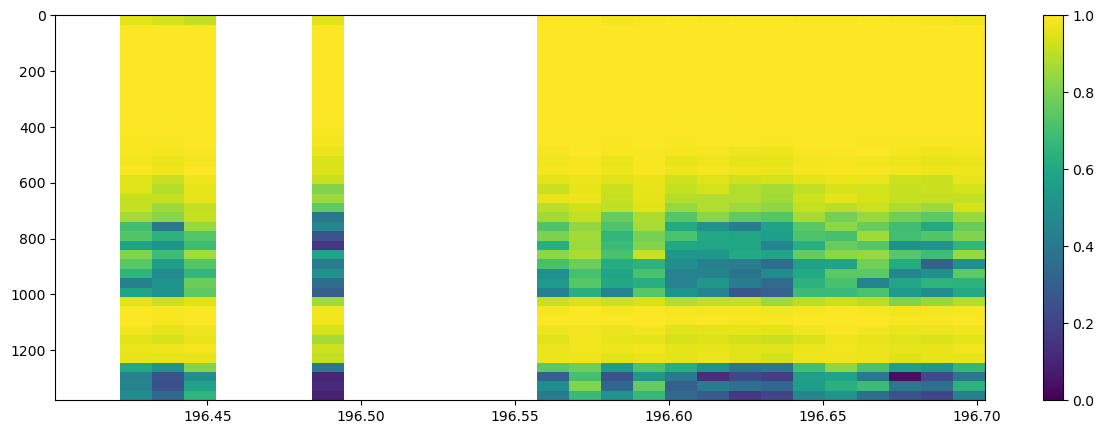

In [35]:
lag = 1
window = 80
b1= test.isel(time=range(0,len(test)-lag))
b2 = test.isel(time=range(lag,len(test)))
ds_20, co_20, phi_20 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_20=ds_20.assign(coherence=(['time','profile_range'],co_20))
ds_20['doy_decimal'] = ds_20.time.dt.dayofyear + (ds_20.time.dt.hour / 24) + (ds_20.time.dt.minute / 1440) + (ds_20.time.dt.second / 86400)
fig, ax = plt.subplots(figsize=(15,5))

plt.pcolormesh(ds_20.doy_decimal,ds_20.profile_range,np.abs(co_20).T,vmin=0,vmax=1)
ax.invert_yaxis()
plt.colorbar()